***
# <font color=blue> Two-Sample Test with  Nearest-Neighbors Density Ratio Estimation</font>

<div style="text-align: right">Andrea De Simone, Thomas Jacques</div>
<div style="text-align: right">arXiv:1807.XXXX</div>
***

In [2]:
%matplotlib inline
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time
from random import randint
from scipy import stats
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors

## Nearest Neighbors Class

In [8]:
class NearestNeighborsClass(object):
    """ 
    Nearest neighbor density ratio estimator
    """
    
    def __init__(self, n_neighbors=2):
        """ 
        Initialize the class instance.
        n_neighbors: number of neighbors for KNN estimator
        """
        self.n_neighbors = n_neighbors


    def fit(self, x_benchmark, x_trial):
        """ 
        Build kd-trees for both samples.
        x_benchmark: benchmark (control) sample
        x_trial: trial (test) sample
        """
        # number of points in the samples
        self.n_benchmark = x_benchmark.shape[0] 
        self.n_trial = x_trial.shape[0]
                    
        # build kd-trees for both samples
        self.nbrs_benchmark = NearestNeighbors(n_neighbors=self.n_neighbors,
                                               algorithm='kd_tree').fit(x_benchmark)
        self.nbrs_trial = NearestNeighbors(n_neighbors=self.n_neighbors+1, 
                                           algorithm='kd_tree').fit(x_trial)

    
    def compute_distances(self, x_q):
        """ 
        Compute distances of Kth-NN in B and T from query points X_q.
        x_q: sample of query data points at which we evaluate the density ratio.
        Return: array of distances of Kth-NN in Benchmark and Trial,  
                and array of coordinates (X_q) for each data point in the query sample.
        """
        # get distances of nearest neighbors in Benchmark from Query points
        distances_B, _ = self.nbrs_benchmark.kneighbors(x_q)
        radii_B = distances_B[:,-1] # distances of Kth-NN
        
        # get distances of nearest neighbors in Trial from Query points
        distances_T, _ = self.nbrs_trial.kneighbors(x_q)
        radii_T = distances_T[:,-1] # distances of Kth-NN
            
        coords = x_q
        
        return(radii_B, radii_T, coords)

## Hypothesis Test Class

In [188]:
class HypothesisTest(object):
    """ 
    Class to perform hypothesis testing with 
    Nearest Neighbors Density Ratio Estimation of pdfs.
    """
    
    def __init__(self, x_benchmark, x_trial, K=5, n_perm=100):
        """ 
        Initialize the class instance.
        """
        self.x_benchmark = x_benchmark
        self.x_trial = x_trial
        self.K = K
        self.n_perm = n_perm
        
        # Number of points in the samples
        self.NB = self.x_benchmark.shape[0] 
        self.NT = self.x_trial.shape[0] 

        # Dimensionality of points
        self.D = self.x_benchmark.shape[1]
        
    def TestStatistic(self, x_b, x_t):
        """
        Compute the test statistic using nearest neighbor density ratio estimator.
        """

        # Instantiate NearestNeighbors class
        NN = NearestNeighborsClass(n_neighbors = self.K)    

        # Build kd-trees with fixed K
        NN.fit(x_b, x_t)  

        # Compute distances r_{j,S}, r_{j,T} of Kth-NN in S and T, with query=Trial
        r_B, r_T, _ = NN.compute_distances(x_t)       
        
        # Compute estimated density ratio on Trial points
        r_hat = np.power(np.divide(r_B, r_T), self.D) * (self.NB/float(self.NT-1))

        # Compute test statistic TS (KL divergence) over Trial points
        TS =  np.mean( np.log(r_hat) )   
    
        return(TS)

    def PermutationTest(self):
        """
        Permutation Test to reconstruct the distribution 
        of the test statistic
        """
        # U = union of B and T
        union_sample = np.concatenate((self.x_benchmark, self.x_trial), axis=0) 
        n_samples = self.NB + self.NT 

        # Initialize array of test statistic values
        self.TS_tilde = np.zeros(self.n_perm, dtype=np.float)        
        
        count=0
        print("Running Permutations... 0%")

        # loop over different samplings
        for i in range(self.n_perm):

            progress = int(round(((i+1)/self.n_perm)*100,0))            
            progress_list = [25, 50, 100]
            if count < len(progress_list) and progress == progress_list[count]:
                count+=1
                print("Running Permutations... {:d}%".format(progress))

            # random sampling U without replacement
            x_resampled = shuffle(union_sample)
            # assign first NB elements to benchmark
            B_resampled = x_resampled[:self.NB] 
            # assign remaning NT elements to trial 
            T_resampled = x_resampled[self.NB:] 

            # Compute the test statistic
            self.TS_tilde[i]  = self.TestStatistic(B_resampled, T_resampled)            

        
    def pvalue(self):
        """
        Perform permutation test and compute the (two-sided) p-value 
        of the observed value of the test statistic
        """
        self.PermutationTest()
        self.TS_obs = self.TestStatistic(self.x_benchmark, self.x_trial)        
        
        # two-sided p-value from TS distribution
        self.p_value = (1 - 0.01 * stats.percentileofscore(self.TS_tilde, abs(self.TS_obs))
                        + 0.01 * stats.percentileofscore(self.TS_tilde, -abs(self.TS_obs)) )

        print("")
        print("TS_obs  = {:.4f}".format(self.TS_obs))
        print("p-value = {:e}".format(self.p_value))
        
    def pvalue_asymptotic(self):
        """
        two-sided p-value from asymptotic normal distribution with mean and variance
        of the permutation disitribution.
        """
        mu = np.mean(HT.TS_tilde) 
        sigma = np.std(HT.TS_tilde) 

        pv = ( stats.norm.cdf(-abs(HT.TS_obs),loc=mu, scale=sigma) 
              + stats.norm.sf(abs(HT.TS_obs),loc=mu, scale=sigma) )
        print("p-value from asymptotic normal = {:e}".format(pv) )
        
    def pvalue_test(self, alpha=0.01): 
        """
        Compare p-value with alpha.
        """
        CL = int((1-alpha)*100)  # confidence level
        
        if self.p_value < alpha:
            print("Null hypothesis rejected at {:d}%CL => distributions are different".format(CL))
        else:
            print("Null hypothesis NOT rejected => distributions are the same")

    def significance(self):
        """
        Convert p-value to significance Z=InverseCDF(1-p) 
        of a zero-mean unit-variance normal distribution.
        """
        Z = stats.norm.ppf(1-self.p_value)
        print("Z = {:.2f} sigma".format(Z))
    
    def TestStatisticDistribution(self, n_bins=20):
        """
        Plot Histogram of test statistic distribution.
        The 'pvalue' method needs to be evaluated first.
        """

        fig, ax = plt.subplots()
        ax.set_xlabel('$\widetilde{TS}$', size=12)
        ax.set_ylabel('$f(\widetilde{TS}|H_0)$', size=12)

        # normalized histogram of test statistic
        weights = np.ones_like(self.TS_tilde)/float(len(self.TS_tilde))
        ax.hist(self.TS_tilde, bins=n_bins, weights=weights, alpha=0.8)
        
        ax.grid(False)
        plt.show()
        
        
    def PlotGaussianComparison(self, n_bins=20):
        """
        Plot Histogram of test statistic distribution 
        together with a gaussian with same mean and std.
        The 'pvalue' method needs to be evaluated first.
        """
        
        fig, ax = plt.subplots()
        ax.set_xlabel('$\widetilde{TS}$', size=12)
        ax.set_ylabel('$f(\widetilde{TS}|H_0)$', size=12)

        # normalized histogram of test statistic
        weights = np.ones_like(self.TS_tilde)/float(len(self.TS_tilde))
        n,bins, _ = ax.hist(self.TS_tilde, bins=n_bins, weights=weights, alpha=0.8)
        bin_width = bins[1]-bins[0]
        
        # plot gaussian distribution 
        mu = np.mean(self.TS_tilde)
        sigma = np.std(self.TS_tilde)
        x_ax=np.linspace(bins[0]-bin_width,bins[-1]+bin_width,1000)
        rv = stats.norm(loc=mu,scale=sigma)
        ax.plot(x_ax, rv.pdf(x_ax)*bin_width, '-', c='r', lw=1, label='gaussian')
        ax.set_xlim([bins[0]-bin_width,bins[-1]+bin_width])        
        
        ax.legend()
        ax.grid(False)
        plt.show()

## Random samples from 2-D gaussian distribution

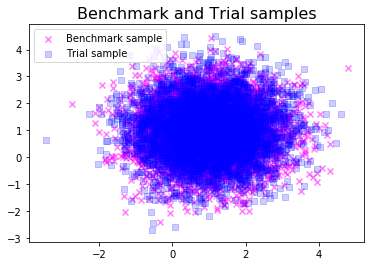

Benchmark sample: 5000 points
Trial sample: 5000 points


In [129]:
class GaussianData(object):
    """ 
    Class to generate 2-dimensional Benchmark and Trial 
    samples from gaussian distributions
    """
    
    def __init__(self, n_points=1000):
        """ 
        Initialize the class instance.
        n_neighbors: number of neighbors for KNN estimator
        """
        self.n_points = n_points


    def generate_data(self):
        """ 
        Generate toy data from two-dim Gaussian distributions
        """
        #'''
        self.mean_b = np.array(([1.0,1.0]))
        self.cov_b  = np.array([[1,0],[0,1]])
        self.mean_t = np.array([1.0,1.0])        
        self.cov_t  = np.array([[1,0.],[0.,1]]) 
        #'''
        '''
        self.mean_b = np.array([1.0,1.0])
        self.cov_b  = np.array([[1,0.],[0.,1]])  
        self.mean_t = np.array([2.2,1.2])  
        self.cov_t  = np.array([[1.,0.],[0.0,1.]])
        '''
        np.random.seed(0)

        L_b = np.linalg.cholesky(self.cov_b)
        L_t = np.linalg.cholesky(self.cov_t)

        self.x_benchmark = np.dot(L_b,(np.random.randn(self.n_points,2) + self.mean_b).T).T
        self.x_trial = np.dot(L_t,(np.random.randn(self.n_points,2) + self.mean_t).T).T
    
    def KL_divergence(self):
        
        mean_1 = self.mean_t
        cov_1  = self.cov_t
        mean_2 = self.mean_b
        cov_2  = self.cov_b
                
        DKL_true = 0.5*( np.linalg.multi_dot([(mean_2-mean_1).T,np.linalg.inv(cov_2),mean_2-mean_1])
                          + np.trace(np.dot(np.linalg.inv(cov_2),cov_1))  
                          + np.log(np.linalg.det(cov_2)/np.linalg.det(cov_1)) - 2  )
        
        return(DKL_true)
    
    def scatter_plot(self):
        """
        Generate plots of benchmark/trial samples in 2D feature space
        """
        fig, ax = plt.subplots()
        cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)

        plt.title('Benchmark and Trial samples', fontsize=16)
        
        plt.scatter(self.x_benchmark[:,0], self.x_benchmark[:,1], c='magenta',
                    alpha=0.5, marker='x',label='Benchmark sample')
        plt.scatter(self.x_trial[:,0],self.x_trial[:,1], c='blue',
                    alpha=0.2, marker='s',label='Trial sample')

        plt.legend(loc='upper left')
        plt.show()

        
#------------------------------------------------------------------------#
gdata = GaussianData(n_points=5000)
gdata.generate_data()
gdata.scatter_plot()

X_benchmark = gdata.x_benchmark
X_trial = gdata.x_trial
#X_trial = X_trial[:3000] # reduce trial sample

print("Benchmark sample: {:d} points".format(X_benchmark.shape[0]))
print("Trial sample: {:d} points".format(X_trial.shape[0])) 

In [155]:
HT = HypothesisTest(X_benchmark, X_trial, K=5)
print("TS (K=5)  =",HT.TestStatistic(X_benchmark, X_trial) )

HT = HypothesisTest(X_benchmark, X_trial, K=20)
print("TS (K=20) =", HT.TestStatistic(X_benchmark, X_trial) )

print("True D_KL = ", gdata.KL_divergence())

TS (K=5)  = 0.008017818334576331
TS (K=20) = 0.0021647287919468136
True D_KL =  0.0


## p-value and distribution of test statistic

In [189]:
HT = HypothesisTest(X_benchmark, X_trial, K=5, n_perm=400)
HT.pvalue()

Running Permutations... 0%
Running Permutations... 25%
Running Permutations... 50%
Running Permutations... 100%

TS_obs  = 0.0080
p-value = 4.650000e-01


In [191]:
HT.pvalue_test(alpha=0.01)

Null hypothesis NOT rejected => distributions are the same


In [192]:
HT.significance()
HT.pvalue_asymptotic()

Z = 0.09 sigma
p-value from asymptotic normal = 4.770968e-01


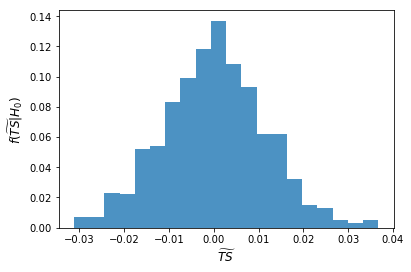

In [144]:
HT.TestStatisticDistribution(n_bins=20)

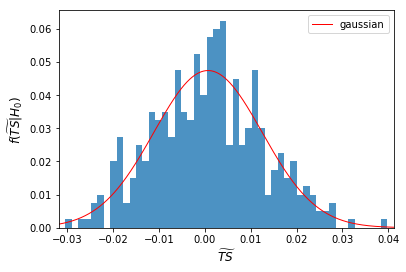

In [167]:
HT.PlotGaussianComparison(n_bins=50)

In [190]:
print( "mean of TS distribution = ", np.mean(HT.TS_tilde) )
print( "std  of TS distribution = ", np.std(HT.TS_tilde) )

mean of TS distribution =  -0.0010829193191818588
std  of TS distribution =  0.011224821505626377


In [131]:
print( np.mean(HT.TS_tilde) )
print( np.std(HT.TS_tilde) )
pp = 0.0359
print( np.sqrt(pp*(1-pp)/(HT.n_perm)) )

-0.000143418574733
0.00775695897469
0.00415999939904


## Convergence in the large-sample limit

In [371]:
p_list = list(range(2,8))
ts_3 = list()
ts_20 = list()
DKL_true = list()

for p in p_list:
    gdata = GaussianData(n_points=10**p)
    gdata.generate_data()

    HT3 = HypothesisTest(gdata.x_benchmark, gdata.x_trial, K=3)
    ts_3.append(HT3.TestStatistic())
    
    HT20 = HypothesisTest(gdata.x_benchmark, gdata.x_trial, K=20)    
    ts_20.append(HT20.TestStatistic())
    

DKL_true = [gdata.KL_divergence()]*len(p_list)    
p10=[10**p for p in p_list]

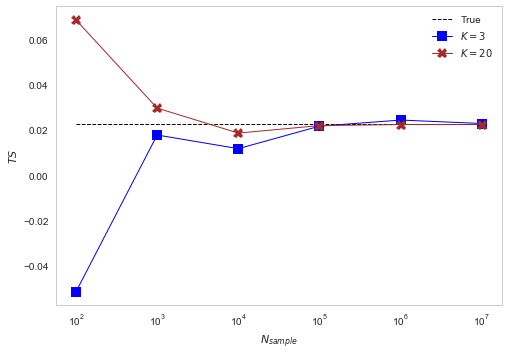

In [373]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()

ax.set_xlabel('$N_{sample}$')
ax.set_ylabel('$TS$')

ax.semilogx(p10, DKL_true, color='black', linestyle='--', linewidth=1, 
           markersize=10, label='True')
ax.semilogx(p10, ts_3, marker='s',color='blue', linestyle='-', linewidth=1, 
           markersize=10, label='$K=3$')
ax.semilogx(p10, ts_20, marker='X',color='brown', linestyle='-', linewidth=1, 
           markersize=10, label='$K=20$')

ax.legend(loc='upper right')

ax.grid()
#plt.savefig('../plots/convergence_2Dgaussians.png')
plt.show()
